In [4]:
import datetime

import pandas as pd
import spacy
import re
import string
import numpy as np
import sys

import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

from spacy.tokens import Token
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

import gensim
from gensim import corpora, models
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec
import multiprocessing

from sklearn.model_selection import cross_val_score , GridSearchCV,train_test_split

from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import enchant
pd.set_option('display.max_rows', 500)

In [111]:
dict_check = enchant.Dict("en_US")

#### Importing the file ####
Path="src/"
Filename='projects_Preprocessed.csv'
df=pd.read_csv(Path+Filename)

Cat_File="category_hier.csv"
Cat_data=pd.read_csv(Path+Cat_File)

varcluster_file="variable_clusters.csv"
varcluster=pd.read_csv(Path+varcluster_file)

#varcluster_info=pd.DataFrame(
#{'cluster_id'  :[ '0' , '1' , '2' , '3' , '4' , '5' , '6' , '7' , '8' , '9' , '10', '11', '12', '13', '14', '15']
#,'cluster_name':[ 'General' ,'Life Sciences' ,'Humanities and Social Sciences' ,'Engineering Sciences' ,'Natural Sciences' ,'Medicine' ,'Foundation & Acquisition' ,'Chemistry & Mechanical & Electrical' ,'Life Sciences' ,'Physics & Mathematical & Geometry & Analytical & Computer' ,'Eco System & Chemistry' ,'History & Cultural' ,'Climate & Earth' ,'Human & Experiment' ,'Biology & Genetics' ,'Text & Publish' ]
#,'category'   :['General', 'Life Sciences', 'Humanities and Social Sciences', 'Engineering Sciences', 'Natural Sciences', 'Life Sciences', 'Uncategorized',  'Uncategorized',  'Life Sciences',  'Uncategorized' , 'Natural Sciences',  'Humanities and Social Sciences',  'Natural Sciences', 'Uncategorized', 'Uncategorized',  'General']
#})

varcluster_info=pd.read_csv(Path+'variable_clusters_info_v2.csv')

df=df[df['Translates']!="The goal of the Heisenberg Program is to enable outstanding scientists who fulfill all the requirements for a long-term professorship to prepare for a scientific leadership role and to work on further research topics during this time. In pursuing this goal, it is not always necessary to choose and implement project-based procedures. For this reason, in the submission of applications and later in the preparation of final reports - unlike other support instruments - no 'summary' of project descriptions and project results is required. Thus, such information is not provided in GEPRIS."]

## Filtering the null abstracts & short description
df=df[(pd.isnull(df.PreProcessedDescription)==False) & (df.PreProcessedDescription.str.strip()!='abstract available')& (df.PreProcessedDescription.str.len()>100) & (pd.isnull(df["SubjectArea"])==False)]

# Striping the category column
Cat_data.Category=Cat_data.Category.str.strip()

## Merging the high level category information

df=df.merge(Cat_data[["File_Categories","Category"]], how="left", left_on="SubjectArea", right_on="File_Categories")

## 1.1 Word Embedding

In [8]:
## Word Embeddings Functions

## Generate the tagged documents (tagging based on the category column)
def create_tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

## Generate the tagged documents (each record in single tag )
def create_tagged_document_based_on_tags(list_of_list_of_words, tags):
    for i in range(len(list_of_list_of_words)):
        yield gensim.models.doc2vec.TaggedDocument(list_of_list_of_words[i], [tags[i]])

## Generate output using the word embedding model prediction - takes long time to regenerate
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs#.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [9]:
## creating a tagged document
DescDict=[[x for x in str(i).split()] for i in df.PreProcessedDescription]
tagged_value_tags = list(create_tagged_document_based_on_tags(DescDict, df.Category.tolist()))
tagged_value = list(create_tagged_document(DescDict))

In [10]:
print(str(datetime.datetime.now()),'Started')

# Init the Doc2Vec model
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=5, epochs=40, alpha = 0.02, dm=1, workers=multiprocessing.cpu_count())

#### Hyper parameter ####
## vector_size  – Dimensionality of the feature vectors.
## If dm=1, ‘distributed memory’ (PV-DM) (CBOW - similar to continuous bag-of-words)
## alpha - The initial learning rate.
## min_count – Ignores all words with total frequency lower than this.

# Build the Volabulary
model.build_vocab(tagged_value)

model.train(tagged_value, total_examples=len(tagged_value), epochs=40)

print(str(datetime.datetime.now()),'Completed')

2020-01-24 10:45:34.346856 Started
2020-01-24 10:51:59.365372 Completed


In [12]:
## Validating the model response for random words 

modelchecked=model
target_word='environment'
print('target_word: %r model: %s similar words:' % (target_word, modelchecked))
for i, (word, sim) in enumerate(modelchecked.wv.most_similar(target_word, topn=20), 1):
    print('    %d. %.2f %r' % (i, sim, word))

target_word: 'environment' model: Doc2Vec(dm/m,d50,n5,w5,mc5,s0.001,t4) similar words:
    1. 0.65 'situation'
    2. 0.65 'system'
    3. 0.63 'constantly'
    4. 0.62 'kind'
    5. 0.61 'way'
    6. 0.60 'habitat'
    7. 0.59 'reservoir'
    8. 0.58 'contexts'
    9. 0.58 'resource'
    10. 0.58 'climatically'
    11. 0.57 'scenario'
    12. 0.57 'continuously'
    13. 0.57 'setting'
    14. 0.57 'potentially'
    15. 0.55 'environments'
    16. 0.55 'object'
    17. 0.55 'community'
    18. 0.55 'circumstance'
    19. 0.55 'obviously'
    20. 0.55 'area'


## 1.2. PCA

In [643]:
## PCA - reducing the dimenstion
ps=20
pcamodel = PCA(n_components=ps)
pca=pcamodel.fit_transform(model.docvecs.vectors_docs)
print('PCA components :',ps,'Variance coveragence' ,np.max(pcamodel.explained_variance_ratio_.cumsum())*100)

PCA components : 20 Variance coveragence 60.63965559005737


In [644]:
dummies=pd.get_dummies(df['Category'])
merged_data=pd.concat([df,dummies], axis=1,ignore_index=False)

merged_data=pd.concat([merged_data,pd.DataFrame(pca)], axis=1,ignore_index=False)

merged_data=merged_data[pd.isnull(merged_data["Category"])==False]
merged_data['DBScanCluster']=0

# 2. DBScan

In [647]:
### DBSCAN - Density-Based Spatial Clustering of Applications with Noise. 
# Finds core samples of high density and expands clusters from them. 

FeatureCols=list(range(ps))

for cat in merged_data.Category.unique():
    print(str(datetime.datetime.now()),'Started')
    CategoricalDS= merged_data[FeatureCols][merged_data.Category==cat]
    clusterer = DBSCAN(eps=4.3, min_samples=5, n_jobs=4)
   
    #### Hyper parameter ####
    # eps - The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
    # min_samples -The number of samples (or total weight) in a neighborhood for a point to be considered as a core point
    
    preds = clusterer.fit_predict(CategoricalDS)
    
    merged_data.loc[merged_data.Category==cat,'DBScanCluster']=preds
    print('******'+cat+'******')
    print(pd.Series(preds).value_counts())
    score = silhouette_score(CategoricalDS, preds, metric='euclidean')
    print('silhouette score:',score)
    print(str(datetime.datetime.now()),'Completed')
    print('')
    

2020-01-24 23:30:47.556463 Started
******Natural Sciences******
 0    13278
-1      446
dtype: int64
silhouette score: 0.26634791
2020-01-24 23:30:58.201233 Completed

2020-01-24 23:30:58.201304 Started
******Humanities and Social Sciences******
 0    9480
-1     504
dtype: int64
silhouette score: 0.26261142
2020-01-24 23:31:04.294582 Completed

2020-01-24 23:31:04.294653 Started
******Engineering Sciences******
 0    8796
-1     580
dtype: int64
silhouette score: 0.22992024
2020-01-24 23:31:11.447007 Completed

2020-01-24 23:31:11.447093 Started
******Life Sciences******
 0    17046
-1      903
dtype: int64
silhouette score: 0.24875018
2020-01-24 23:31:39.514838 Completed



In [590]:
merged_data['DBScanCluster'].value_counts()

 0    49373
-1     1660
Name: DBScanCluster, dtype: int64

In [648]:
## Reseting the index, converting category to int for supervised learning

def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1

merged_data=merged_data.reset_index()[merged_data.columns[0:]]

merged_data['CategoryConv']=merged_data.Category.apply(CattoID)

merged_data['CategoryConv']=merged_data['CategoryConv'].astype('int')

# 3. Supervised learning

In [649]:
Features=merged_data.columns[16:len(merged_data.columns)-2] #list(range(500))

merged_data[Features]=MinMaxScaler().fit_transform(merged_data[Features])

OP_Feature='CategoryConv'

## Training & Test data are splitted based on the DBScanCluster result. outlier data are considering as test data to reevaluate.

X_Training_DS=merged_data[Features][merged_data.DBScanCluster==0]
y_Training_DS=merged_data[OP_Feature][merged_data.DBScanCluster==0]

X_Test_DS=merged_data[Features][merged_data.DBScanCluster!=0]
y_Test_DS=merged_data[OP_Feature][merged_data.DBScanCluster!=0]

X_train, X_test, y_train, y_test = train_test_split(X_Training_DS,y_Training_DS,  test_size=0.2, random_state=0)

## 3.1 NaiveBayes

Accuracy Score : 34.88683127572016


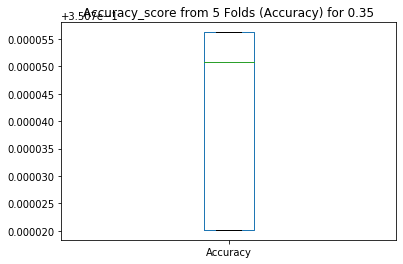

In [650]:
modelNB = MultinomialNB(alpha=1)

#### Hyper parameter ####
# alpha - Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

modelNB.fit(X_train, y_train)

nfolds=5
scores=cross_val_score(modelNB, X_Training_DS,y_Training_DS, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

y_pred = modelNB.predict(X_test)
print('Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))

## 3.1  k-nearest neighbors 

In [595]:
for k in [4,8,16,25,30]:
    modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    #### Hyper parameter ####
    # n_neighbors - Number of neighbors to use by default for kneighbors queries
    # weights - weight function used in prediction (‘distance’ : weight points by the inverse of their distance. 
    #in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.)
   
    modelKBC.fit(X_train, y_train)

    y_pred = modelKBC.predict(X_test)
    print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

    #nfolds=3
    #scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
    #pd.Series(scores).plot(kind="box", label="Accuracy");
    #plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

neighbors: 4 Accuracy Score : 0.8643037974683544
neighbors: 8 Accuracy Score : 0.8755443037974684
neighbors: 16 Accuracy Score : 0.8803037974683544
neighbors: 25 Accuracy Score : 0.8821265822784811
neighbors: 30 Accuracy Score : 0.8827341772151899


neighbors: 25 Accuracy Score : 0.8868312757201646


Text(0.5, 1.0, 'Accuracy_score from 3 Folds (Accuracy) for 0.88')

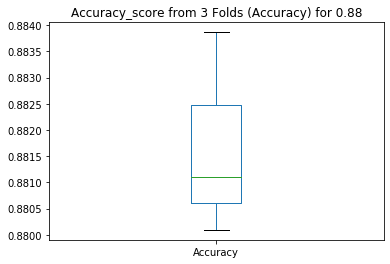

In [651]:
k=25
modelKBC = KNeighborsClassifier(n_neighbors=k, weights='distance')
modelKBC.fit(X_train, y_train)

y_pred = modelKBC.predict(X_test)
print('neighbors:',k,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )))

nfolds=3
scores=cross_val_score(modelKBC, X_train,y_train, cv=nfolds, scoring="accuracy")
pd.Series(scores).plot(kind="box", label="Accuracy");
plt.title('Accuracy_score from '+str(nfolds)+' Folds (Accuracy) for '+str(round(pd.Series(scores).mean(), 2)))

In [597]:
for x in [.01]+list(np.linspace(0.1,1,5))+[10]:

    modelSVC = svm.LinearSVC(C=x).fit(X_train, y_train)
    #### Hyper parameter ####
    # C - The strength of the regularization is inversely proportional to C.

    y_pred = modelSVC.predict(X_test)
    print('C -',x,'Accuracy Score : '+str(accuracy_score(y_test,y_pred )*100))


C - 0.01 Accuracy Score : 83.73670886075949
C - 0.1 Accuracy Score : 84.0
C - 0.325 Accuracy Score : 83.96962025316455
C - 0.55 Accuracy Score : 83.95949367088608
C - 0.775 Accuracy Score : 83.9493670886076
C - 1.0 Accuracy Score : 83.96962025316455
C - 10 Accuracy Score : 83.97974683544304


/Users/balaji/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


## 4. Formatting the output categories based on the predict_proba

In [711]:
## Based on predict_proba result. reorder to values and categories based on high probablity.

def name_max_value(DF):
    colname='Category_1_Values'
    if (DF['Engineering Sciences']==DF[colname]):
        return 'Engineering Sciences'
    elif (DF['Humanities and Social Sciences']==DF[colname]):
        return 'Humanities and Social Sciences'
    elif (DF['Natural Sciences']==DF[colname]):
        return 'Natural Sciences'
    elif (DF['Life Sciences']==DF[colname]):
        return 'Life Sciences'
    else:
        return ''
    
def name_sec_max_value(DF):
    colname='Category_2_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_1']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_1']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_1']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_1']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
def name_3rd_max_value(DF):
    colname='Category_3_Values'
    if(DF[colname]==0):
        return ''
    elif ((DF['Engineering Sciences']==DF[colname]) & (DF['Category_2']!='Engineering Sciences')):
        return 'Engineering Sciences'
    elif ((DF['Humanities and Social Sciences']==DF[colname]) & (DF['Category_2']!='Humanities and Social Sciences')):
        return 'Humanities and Social Sciences'
    elif ((DF['Natural Sciences']==DF[colname]) & (DF['Category_2']!='Natural Sciences')):
        return 'Natural Sciences'
    elif ((DF['Life Sciences']==DF[colname]) & (DF['Category_2']!='Life Sciences')):
        return 'Life Sciences'
    else:
        return ''
    
cols=['Engineering Sciences','Humanities and Social Sciences','Natural Sciences','Life Sciences']
PredictedValues=pd.DataFrame(modelKBC.predict_proba(merged_data[Features]), columns=cols)
PredictedValues['Category_1_Values']=PredictedValues[cols].apply(np.max,axis=1)
PredictedValues['Category_2_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[2])
PredictedValues['Category_3_Values']=PredictedValues[cols].apply(np.sort,axis=1).apply(lambda x:x[1])

PredictedValues['Category_1']=PredictedValues.apply(name_max_value,axis=1)
PredictedValues['Category_2']=PredictedValues.apply(name_sec_max_value,axis=1)
PredictedValues['Category_3']=PredictedValues.apply(name_3rd_max_value,axis=1)

PredictedValues['Category_12_Variance']=PredictedValues.apply(lambda x :x['Category_1_Values']-x['Category_2_Values'], axis=1)
PredictedValues['Category_23_Variance']=PredictedValues.apply(lambda x :x['Category_2_Values']-x['Category_3_Values'], axis=1)

In [718]:
PredictedValues.loc[PredictedValues['Category_3_Values']<=.15,'Category_3']=''
PredictedValues.loc[PredictedValues['Category_2_Values']<=.15,'Category_2']=''

PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_2']=''
PredictedValues.loc[PredictedValues['Category_1_Values']>=.80,'Category_3']=''



## 5.1. Random manual result evaluvation 

In [748]:
## regenerating dataset

NewMergedDSAligned=pd.concat([merged_data[merged_data.columns.tolist()[:12]+['DBScanCluster']],PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

In [749]:
fil_1_2=(NewMergedDSAligned['Category_12_Variance']<=.10) & ((NewMergedDSAligned['Category_1']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))
fil_2_3=(NewMergedDSAligned['Category_23_Variance']<=.10) & ((NewMergedDSAligned['Category_3']==NewMergedDSAligned['Category']) | (NewMergedDSAligned['Category_2']==NewMergedDSAligned['Category']))

NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_1']=NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category']
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_2']=''
NewMergedDSAligned.loc[(fil_1_2 | fil_2_3) ,'Category_3']=''

In [750]:
#(NewMergedDSAligned.DBScanCluster!=0) &

NewMergedDSAligned['DBScanCluster'][ (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

 0    824
-1    450
Name: DBScanCluster, dtype: int64

In [751]:
NewMergedDSAligned['DBScanCluster'].value_counts()

 0    48600
-1     2433
Name: DBScanCluster, dtype: int64

In [752]:
NewMergedDSAligned['Category'][(NewMergedDSAligned.DBScanCluster!=0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].value_counts()

Engineering Sciences              154
Natural Sciences                  144
Life Sciences                     106
Humanities and Social Sciences     46
Name: Category, dtype: int64

In [755]:
cats='Natural Sciences'
lim=240
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster==0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
32373,Our aim is to understand the molecular mechani...,Natural Sciences,0.561592,0.438408,0.000000,Life Sciences,Natural Sciences,,0.123183,0.438408
17455,Megacities are results of globalisation proces...,Natural Sciences,0.561352,0.231668,0.166861,Humanities and Social Sciences,Life Sciences,Engineering Sciences,0.329683,0.064807
36766,Mass spectrometry is the central measurement t...,Natural Sciences,0.561100,0.320325,0.118575,Life Sciences,Natural Sciences,,0.240775,0.201749
33560,The reduction of the thermal lattice conductiv...,Natural Sciences,0.559614,0.440386,0.000000,Engineering Sciences,Natural Sciences,,0.119228,0.440386
11786,The goal of this research project is to detect...,Natural Sciences,0.559331,0.278895,0.161773,Life Sciences,Natural Sciences,Engineering Sciences,0.280436,0.117122


In [756]:
#cats='Humanities and Social Sciences'
NewMergedDSAligned[['Translates','Category_1_Values']][(NewMergedDSAligned['Category_1']!=cats) &  (NewMergedDSAligned['Category']==cats) & (NewMergedDSAligned.DBScanCluster==0) & (NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1'])].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()#.tail().

['Our aim is to understand the molecular mechanism of channel formation in biomembranes by “peptaibols”, which are supposed to permeabilize bacteria membranes by assembling into transmembrane bundles. As these antimicrobial peptides contain a high proportion of the unusual α-aminoisobutyric acid (Aib), such peptAIBols are difficult to synthesize and to analyze, hence their mode of action is poorly understood. Especially some very short sequences are unlikely to be able to span the membrane, yet they can be just as potent as the typical longer antimicrobial sequences. To gain insight into their functional mechanisms, a comparative structure analysis is envisaged, using solid-state 19F-NMR spectroscopy on two membrane-embedded peptaibols with different length: the well-known 20-mer Alamethicin F30/3 (ALM), and the short 11-mer Harzianin HK-VI (HZ). For these highly sensitive NMR measurements, specific tailor-made trifluoromethyl-(Tfm-)labeled amino acids need to be designed and incorpora

In [659]:
#NewMergedDSAligned.to_csv(Path+'WEPCADBScanFindingsKMeans.csv', index=False)

## 5.2. Each category TF/IDF based result evaluvation 

In [757]:
#&(NewMergedDSAligned['Category']==cats) &(NewMergedDSAligned['Category_1']==check_cat)

input_data=NewMergedDSAligned[(NewMergedDSAligned['Category']!=NewMergedDSAligned['Category_1']) & (NewMergedDSAligned.DBScanCluster!=0) ]

input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1','Category_2','Category_3']].apply(lambda x:x[0]+','+x[1]+','+x[2]+','+x[3], axis=1)
#input_data.loc[:,'CategoryCollc']=input_data[['Category','Category_1']].apply(lambda x:x[0]+','+x[1], axis=1)
input_data.loc[:,'CategoryCollc']=input_data['CategoryCollc'].str.strip(",")

/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/balaji/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [758]:
varcluster_info.cluster_id=varcluster_info.cluster_id.astype('int32')
varclusterall=varcluster.merge(varcluster_info, how='left',left_on='Cluster', right_on='cluster_id')
varclusterall=varclusterall[varclusterall.RS_Ratio<.98]

In [759]:
def find_category(target_word):
    try :
        sim_word=list(map(lambda x:x[0] ,modelchecked.wv.most_similar(target_word, topn=5)))
        finalcategory=varclusterall[varclusterall.Variable.isin(sim_word)].category.value_counts().sort_values(ascending=False).head(1).index
        if(len(finalcategory)>0):
            return finalcategory[0]
        else:
            return np.NaN
    except :
        return np.NaN

In [760]:
sizes=len(input_data.CategoryCollc.unique())
#plt.subplots(figsize=(8,150)) 
j=1

for i,bucket in input_data.groupby(['CategoryCollc']):
    
    print(i.split(',')[0],'-',i.split(',')[1:],': Number of Documents -',len(bucket))
    
    if(len(bucket)>1):
        vectorizer = TfidfVectorizer(max_features=20, ngram_range=(1, 1))
        review_vectors = vectorizer.fit_transform(bucket["PreProcessedDescription"])
        features_df = pd.DataFrame(review_vectors.toarray(), columns = vectorizer.get_feature_names())

        varcat=pd.DataFrame(features_df.sum().sort_values(ascending=False)).merge(varclusterall, how='left', left_index=True, right_on='Variable')[['Variable','category']]
        varcat.category=varcat[['Variable', 'category']].apply(lambda x: find_category(x.Variable) if(pd.isnull(x['category'])) else x['category'], axis=1)

        #print(varcat.category.value_counts())
        #print(varcat.apply(lambda x: x.Variable +' - NA' if(pd.isnull(x.category)) else x.Variable +'  - '+x.category , axis=1))
        print('Rare words',list(varcat[varcat.category!='General'].Variable))
    
    else:
        print(bucket.Translates.tolist())
    
    print('----------------------------------------------------------')
    
    #print(features_df.sum().sort_values(ascending=False),'\n')
    
    #vectorizer.get_feature_names()
 
    #plt.subplot(1,sizes,j)
    #features_df.sum().sort_values(ascending=False).plot(kind='bar',color='green')
    #plt.title(i.split(',')[0]+' -'+','.join(i.split(',')[1:]))
    #plt.xticks(rotation=60)
    
    #j=j+1
    #plt.tight_layout()
    

Engineering Sciences - ['Humanities and Social Sciences'] : Number of Documents - 17
Rare words ['urban', 'research', 'architectural', 'effect', 'design', 'architecture', 'approach', 'system', 'new', 'question', 'planning', 'process', 'develop', 'medium', 'study', 'practice']
----------------------------------------------------------
Engineering Sciences - ['Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 15
Rare words ['research', 'system', 'model', 'user', 'analysis', 'study', 'aspect', 'process', 'use', 'building', 'method', 'design', 'language', 'urban', 'ranking']
----------------------------------------------------------
Engineering Sciences - ['Humanities and Social Sciences', 'Engineering Sciences', 'Life Sciences'] : Number of Documents - 1
['Working in the cold with temperatures below -20 ° C places considerable demands on the thermoregulation of humans, even when wearing cold protection clothing, with the result that the energy expenditure in

Rare words ['surface', 'structure', 'phase', 'flow', 'field', 'model', 'particle', 'symmetry', 'reaction', 'mechanism', 'process', 'interface', 'property', 'ion', 'cell', 'study', 'perovskite']
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences', 'Engineering Sciences'] : Number of Documents - 34
Rare words ['process', 'problem', 'system', 'method', 'material', 'research', 'property', 'model', 'field', 'control', 'high', 'approach', 'develop', 'structure', 'effect', 'glass', 'phase']
----------------------------------------------------------
Engineering Sciences - ['Natural Sciences', 'Life Sciences'] : Number of Documents - 6
Rare words ['nanoparticle', 'membrane', 'label', 'detection', 'protein', 'polymer', 'hydrogel', 'different', 'structure', 'surface', 'molecule', 'system', 'large', 'develop', 'property', 'conformer', 'method', 'conformation']
----------------------------------------------------------
Engineering Sciences - ['Natur

Rare words ['cell', 'field', 'circadian', 'functional', 'network', 'protein', 'use', 'increase', 'activity', 'function', 'speech', 'emotional', 'region', 'cognitive', 'comprehension', 'fmri', 'change', 'associate', 'gyrus', 'angular']
----------------------------------------------------------
Humanities and Social Sciences - ['Life Sciences', 'Engineering Sciences', 'Humanities and Social Sciences'] : Number of Documents - 1
['Surgeries are measures to improve the quality of life. In some cases, the procedures are even life-saving. Surgeries require many resources, including surgeons, anesthesiologists, nurses, tools and devices, an operating room and a bed in a care unit directly following the surgery. If one resource is not available, the surgery must be postponed, reducing the health care service level. Therefore, a surgery scheduling approach should take limited resources and stochasticity into account. This leads to shorter waiting times for surgeries (by higher utilization of ope

Rare words ['game', 'graph', 'logical', 'solution', 'theory', 'diagram', 'type', 'cooperative', 'dynamic', 'evolutionary', 'lovász', 'shapley', 'system', 'äôs', 'hypergraph', 'use', 'proof', 'relationship']
----------------------------------------------------------
Humanities and Social Sciences - ['Natural Sciences', 'Humanities and Social Sciences'] : Number of Documents - 3
Rare words ['wittgenstein', 'refutation', 'theory', 'frame', 'ramsey', 'classification', 'identity', 'proof', 'notion', 'view', 'logic', 'proposal', 'system', 'conception', 'understanding', 'central', 'different', 'relation']
----------------------------------------------------------
Humanities and Social Sciences - ['Natural Sciences', 'Life Sciences'] : Number of Documents - 1
['Within a cross section, the morphology of compact bone can display dramatic variation in microarchitecture and therefore strength properties. The endosteal lamellar pocket (ELP), an easily-defined, dense, lamellar region of the long bon

Rare words ['process', 'system', 'modeling', 'image', 'reconstruction', 'phase', 'field', 'method', 'development', 'noise', 'experimental', 'model', 'flow', 'develop', 'event', 'new', 'research']
----------------------------------------------------------
Life Sciences - ['Humanities and Social Sciences'] : Number of Documents - 15
Rare words ['research', 'study', 'health', 'care', 'human', 'model', 'child', 'life', 'policy', 'factor', 'ethical', 'hl', 'decision', 'identify', 'parent', 'relate', 'ecap', 'non']
----------------------------------------------------------
Life Sciences - ['Humanities and Social Sciences', 'Engineering Sciences'] : Number of Documents - 1
["Many real-life decisions must be made in the face of risk that is due to uncertain information about the choice situation. At least two types of uncertainty can result in decision risk: (1) the uncertain consequences of the decision maker‚Äôs choice and (2) the decision maker‚Äôs uncertain knowledge about the choice situa

Rare words ['soil', 'water', 'change', 'model', 'effect', 'microbial', 'surface', 'organic', 'flux', 'process', 'carbon', 'study', 'scale', 'system', 'flow', 'different', 'dna', 'lake', 'ch4', 'mat']
----------------------------------------------------------
Natural Sciences - ['Engineering Sciences'] : Number of Documents - 21
Rare words ['model', 'process', 'method', 'property', 'material', 'develop', 'user', 'strain', 'new', 'high', 'transfer', 'different', 'sensor', 'map', 'tire']
----------------------------------------------------------
Natural Sciences - ['Engineering Sciences', 'Humanities and Social Sciences'] : Number of Documents - 5
Rare words ['network', 'spatial', 'model', 'orientation', 'aa', 'navigation', 'osm', 'quality', 'map', 'domain', 'develop', 'system', 'different', 'indicator', 'cognitive']
----------------------------------------------------------
Natural Sciences - ['Engineering Sciences', 'Life Sciences'] : Number of Documents - 2
Rare words ['ha', 'step', 'j

Rare words ['chapter', 'earth', 'shf', 'market', 'global', 'future', 'value', 'food', 'livelihood', 'human', 'science', 'geoscience', 'trade', 'organic', 'fair', 'domestic', 'debate', 'country', 'system']
----------------------------------------------------------
Natural Sciences - ['Humanities and Social Sciences', 'Natural Sciences'] : Number of Documents - 5
Rare words ['sand', 'social', 'map', 'water', 'housing', 'network', 'area', 'resource', 'study', 'urban', 'local', 'world', 'process', 'different', 'community', 'movement', 'research', 'analysis', 'approach']
----------------------------------------------------------
Natural Sciences - ['Humanities and Social Sciences', 'Natural Sciences', 'Life Sciences'] : Number of Documents - 1
['More and more innovations are being generated in emerging economies. First and foremost, this concerns the adaptation of existing products and solutions to local markets, secondly and less commonly, the development of global novelties or radical inn

In [763]:
cats='Engineering Sciences'
cat1='Humanities and Social Sciences'
cat2='Life Sciences'
cat3=''  #'Natural Sciences'
 
lim=200
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][  (NewMergedDSAligned['Category']==cats)  &  (NewMergedDSAligned['Category_1']==cat1) &  (NewMergedDSAligned['Category_2']==cat2) &  (NewMergedDSAligned['Category_3']==cat3)].sort_values('Category_1_Values', ascending=False).head(lim).tail(5)

,Translates,Category,Category_1_Values,Category_2_Values,Category_3_Values,Category_1,Category_2,Category_3,Category_12_Variance,Category_23_Variance
37335,According to a representative survey of the Fe...,Engineering Sciences,0.760858,0.157743,0.081399,Humanities and Social Sciences,Life Sciences,,0.603115,0.076344
36972,The research project aims to analyse administr...,Engineering Sciences,0.722411,0.158573,0.119016,Humanities and Social Sciences,Life Sciences,,0.563838,0.039556
48194,"Research involving anatomy-related, objectivyi...",Engineering Sciences,0.599230,0.284027,0.116743,Humanities and Social Sciences,Life Sciences,,0.315203,0.167284
47772,Researchers commonly identify two main phenome...,Engineering Sciences,0.482124,0.396088,0.121787,Humanities and Social Sciences,Life Sciences,,0.086036,0.274301
10011,Artificial head technology is highly developed...,Engineering Sciences,0.475980,0.406470,0.117550,Humanities and Social Sciences,Life Sciences,,0.069510,0.288921


In [764]:
NewMergedDSAligned[['Translates','Category']+NewMergedDSAligned.columns[13:].tolist()][  (NewMergedDSAligned['Category']==cats)  &  (NewMergedDSAligned['Category_1']==cat1) &  (NewMergedDSAligned['Category_2']==cat2) &  (NewMergedDSAligned['Category_3']==cat3)].sort_values('Category_1_Values', ascending=False).Translates.head(lim).tail(5).tolist()

["According to a representative survey of the Federal Environment Ministry 27% of the Germans see their own and their families' health endangered by noise. Indeed many investigations on the effect of noise uncover significant correlations between noise exposure and health hazards, e.g. in the case of cardiovascular or psychiatric diseases. Thereby, the subjective assessment of a sound event is of crucial importance since it may lead to perceived annoyance and cause physiological stress reactions. Thus, the aim of the project is to gain a profound understanding of cognitive processes, in particular attention and memory processes, being involved in sound evaluations. Common experiences like listening to a Soundscape can be separated into several streams of transient states that vary in intensity from moment to moment. Several studies, e.g. on pain perception, show that retrospective judgements could be well explained by an unweighted combination of the most extreme affect (peak) experien

# Visualization

In [765]:
def CattoID(input_cat):
    if(input_cat=='Engineering Sciences'):
        return 0
    elif(input_cat=='Humanities and Social Sciences'):
        return 1
    elif(input_cat=='Natural Sciences'):
        return 2
    elif(input_cat=='Life Sciences'):
        return 3
    else :
        return -1


NewMergedDSAligned2=pd.concat([merged_data,PredictedValues[PredictedValues.columns[4:]]], axis=1, ignore_index=False)

NewMergedDSAligned2.loc[:,'Category_1_ID']=NewMergedDSAligned2.Category_1.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_2_ID']=NewMergedDSAligned2.Category_2.apply(CattoID)
NewMergedDSAligned2.loc[:,'Category_3_ID']=NewMergedDSAligned2.Category_3.apply(CattoID)

NewMergedDSAligned2=pd.DataFrame(enumerate(NewMergedDSAligned2.SubjectArea.unique()), columns=['Subjectid','SubjectAreaMatching']).merge(NewMergedDSAligned2,left_on='SubjectAreaMatching', right_on='SubjectArea')

cats=['Engineering Sciences','Humanities and Social Sciences', 'Life Sciences','Natural Sciences']
cats_dist=[]

## Finiding the overall similiarity

for c, w in NewMergedDSAligned2[(NewMergedDSAligned2['Category']!=NewMergedDSAligned2['Category_1']) & (NewMergedDSAligned2['DBScanCluster']!=0)].groupby('Category'):
    #print('')
    #print(c, len(w))
    #other_cat=list(filter(lambda x:x!=c, cats))
    cat_dist=[]
    for oc in cats:
        if oc==c:
            oc_sim=0
            
        else:
            oc_sum=sum(w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist())
            oc_sim=oc_sum/len(w)
            
        cat_dist.append(oc_sim)
        #print(c,':',oc,'-', round(oc_sim,2))
        
        #oc_sum=w[w['Category_1']==oc].Category_1_Values.tolist()+w[w['Category_2']==oc].Category_2_Values.tolist()+w[w['Category_3']==oc].Category_3_Values.tolist()
        #oc_sim=sum(oc_sum)/len(oc_sum)
        #print(c,':',oc,'-', round(oc_sim,2))
    cats_dist.append(np.array(cat_dist))
cats_dist=np.array(cats_dist)

## Making symmetric matrix
sym_dist=np.zeros(cats_dist.shape)
for i in range(cats_dist.shape[0]):
    for j in range(cats_dist.shape[0]):
        sym_dist[i][j]=cats_dist[i][j]+ cats_dist[j][i]
        if(i==j):
            sym_dist[i][j]=1

# 1-x : convert similiarity to distance
sym_dist=1-pd.DataFrame(sym_dist, columns=cats, index=cats)

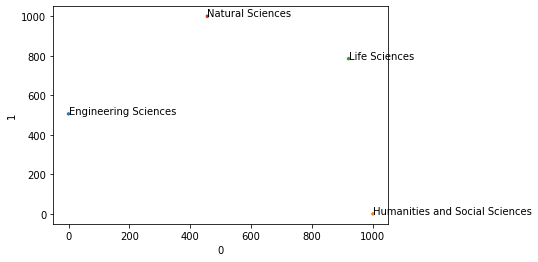

In [779]:
## Generating coordinates from distance

#, angle=0.8

#coords = TSNE(n_components=2,perplexity=.1, random_state=12, metric='precomputed').fit_transform(sym_dist)

coords = TSNE(n_components=2,perplexity=1.9, random_state=7, metric='precomputed').fit_transform(sym_dist)
#coords = PCA(n_components=2).fit_transform(sym_dist)

coords=MinMaxScaler([0,1000]).fit_transform(coords)
coords=pd.DataFrame(coords, index=cats).reset_index()
p1=sns.scatterplot(
    x=0, y=1,
    hue="index",
 #   palette=sns.color_palette("hls", 4),
    data=coords,
   # legend="full",
    alpha=1,
    size = 8,
    legend=False
);

for line in range(0,coords.shape[0]):
     p1.text(coords[0][line]+0.01, coords[1][line], cats[line], horizontalalignment='left',  size='medium', color='black')

In [774]:
sym_dist

,Engineering Sciences,Humanities and Social Sciences,Life Sciences,Natural Sciences
Engineering Sciences,0.000000,0.517014,0.580514,0.452677
Humanities and Social Sciences,0.517014,0.000000,0.441687,0.766188
Life Sciences,0.580514,0.441687,0.000000,0.299601
Natural Sciences,0.452677,0.766188,0.299601,0.000000


In [780]:
newrange=pd.DataFrame(NewMergedDSAligned2.Category.value_counts()/80).reset_index().merge(coords,left_on='index',right_on='index')
newrange.loc[:,'Min_X']=newrange[0]-newrange['Category']
newrange.loc[:,'Max_X']=newrange[0]+newrange['Category']
newrange.loc[:,'Min_Y']=newrange[1]-(newrange['Category']*.60)
newrange.loc[:,'Max_Y']=newrange[1]+(newrange['Category']*.60)

newrange.columns=['Category','size', 0, 1, 'Min_X', 'Max_X', 'Min_Y', 'Max_Y']
newrange

,Category,size,0,1,Min_X,Max_X,Min_Y,Max_Y
0,Life Sciences,224.3625,920.239258,785.231201,695.876758,1144.601758,650.613701,919.848701
1,Natural Sciences,171.5500,456.020660,999.999878,284.470660,627.570660,897.069878,1102.929878
2,Humanities and Social Sciences,124.8000,1000.000000,0.000000,875.200000,1124.800000,-74.880000,74.880000
3,Engineering Sciences,117.2000,0.000000,506.059937,-117.200000,117.200000,435.739937,576.379937


In [781]:
pca.shape

(51033, 20)

In [782]:
catsperplexity={'Engineering Sciences':5,'Humanities and Social Sciences':5, 'Life Sciences':10,'Natural Sciences':8}

## T-SNE separately for each categories

outerclusterfeatures=['Category_1_Values','Category_1_ID','Category_2_ID','Category_2_Values','Category_3_ID','Category_3_Values','Subjectid']
#Doc2VecModelData=pd.concat([pd.DataFrame(model.docvecs.vectors_docs),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
Doc2VecModelData=pd.concat([pd.DataFrame(pca[:,:10]),NewMergedDSAligned2[outerclusterfeatures]], axis=1)
    
Doc2VecModelData['tsne-2d-one']=0
Doc2VecModelData['tsne-2d-two']=0

for cat in cats:#['Life Sciences']:#
    print(str(datetime.datetime.now()),'Started for', cat)
    
    tsne = TSNE(n_components=2, perplexity=catsperplexity[cat], n_iter=300, random_state=0, learning_rate=100)
    ## The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. 
    ## Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. 
    
    tsne_results = tsne.fit_transform(Doc2VecModelData[NewMergedDSAligned2.Category==cat])
    
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-one'] = tsne_results[:,0]
    Doc2VecModelData.loc[NewMergedDSAligned2.Category==cat,'tsne-2d-two'] = tsne_results[:,1]

    print(str(datetime.datetime.now()),'Completed for', cat)
    

Doc2VecModelData.loc[:,'Category'] = NewMergedDSAligned2.Category
Doc2VecModelData.loc[:,'Category_1'] = NewMergedDSAligned2.Category_1


2020-01-25 00:55:59.414709 Started for Engineering Sciences
2020-01-25 00:56:20.423772 Completed for Engineering Sciences
2020-01-25 00:56:20.423945 Started for Humanities and Social Sciences
2020-01-25 00:56:42.144700 Completed for Humanities and Social Sciences
2020-01-25 00:56:42.145127 Started for Life Sciences
2020-01-25 00:57:28.554360 Completed for Life Sciences
2020-01-25 00:57:28.554580 Started for Natural Sciences
2020-01-25 00:58:01.134946 Completed for Natural Sciences


In [783]:
# Reshaping
for cat in cats:
    model_x=MinMaxScaler([newrange[newrange['Category']==cat].Min_X.values[0],newrange[newrange['Category']==cat].Max_X.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-one']=model_x.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-one']])

    model_y=MinMaxScaler([newrange[newrange['Category']==cat].Min_Y.values[0],newrange[newrange['Category']==cat].Max_Y.values[0]])
    Doc2VecModelData.loc[Doc2VecModelData['Category']==cat,'tsne-2d-two']=model_y.fit_transform(Doc2VecModelData[Doc2VecModelData['Category']==cat][['tsne-2d-two']])


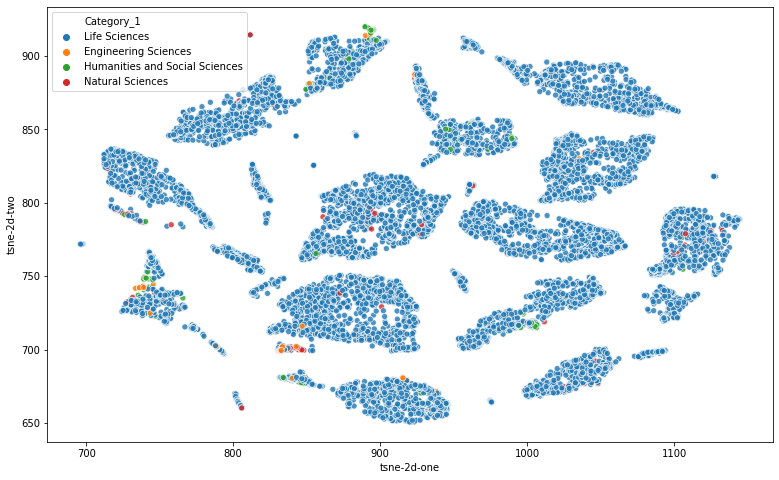

In [784]:
cat='Life Sciences'#'Engineering Sciences'#'Life Sciences'#'Humanities and Social Sciences'#'Life Sciences'#'
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData[Doc2VecModelData.Category==cat],
        legend="full",
#        style='Category_1',
        alpha=0.8
    );

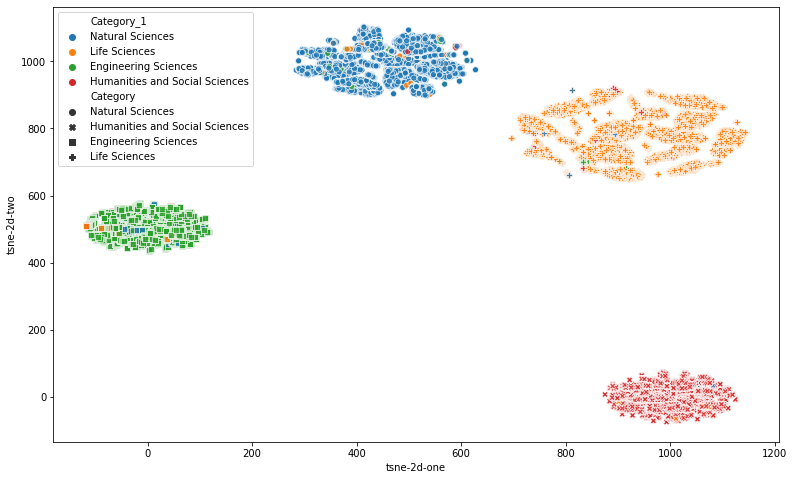

In [785]:
plt.figure(figsize=(13,8))
sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="Category_1",
        data=Doc2VecModelData,
        legend="full",
        style='Category',
        alpha=0.8
    );

In [786]:
def label_genarator(input):
    if((input.Category==input.Category_1) or (input.DBScanCluster==0)):
        return ''#'Category : '+input.Category
    else:
        if((input.Category_3_Values==0) and (input.Category_2_Values==0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%'+')'
        elif((input.Category_3_Values==0) and (input.Category_2_Values!=0)):
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%)'
        else:
            return '('+input.Category_1+' '+str(round(input.Category_1_Values*100))+'%, '+input.Category_2+' '+str(round(input.Category_2_Values*100))+'%, '+input.Category_3+' '+str(round(input.Category_3_Values*100))+'%)'
        
        
Report_extrat=pd.concat([NewMergedDSAligned2[['Name','Institution','FundingFrom','FundingEnd', 'Category','Category_1_Values','Category_2_Values','Category_3_Values','Category_1','Category_2','Category_3','DBScanCluster']],Doc2VecModelData[['tsne-2d-one', 'tsne-2d-two']]], axis=1)
Report_extrat['ProjectURL']=NewMergedDSAligned2.SubUrl.apply(lambda x:'https://gepris.dfg.de'+x)
Report_extrat['label']=Report_extrat.apply(label_genarator, axis=1)
Report_extrat['interdiscipilinary']=False
Report_extrat.loc[(Report_extrat.label!='') & (Report_extrat['DBScanCluster']!=0),'interdiscipilinary']=True

In [787]:
Report_extrat['color']=Report_extrat['Category']
Report_extrat.loc[Report_extrat['interdiscipilinary'],'color']=Report_extrat.loc[Report_extrat['interdiscipilinary'],'Category_1']

In [789]:
Report_extrat.to_csv(Path+'Report_WEPCADBScanFindingsKMeansV2_Exp1.1.0.csv', index=False)
newrange.to_csv(Path+'CATRANGE_WEPCADBScanFindingsKMeansV2_Exp1.1.0.csv', index=False)